# Libraries

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import warnings

from pandas.errors import SettingWithCopyWarning
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from utils import *

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

# Data import

## Antibdy pair sequence dataframes

In [2]:
both_chains = pd.read_csv(os.path.dirname(os.getcwd()) + 
    "/data/antibody_pairs/Antibody_pairs_backtranslated_both_chains.csv")

## Epitope ID to PDB mapping

In [3]:
epitope_id_pdb_human = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Epitope_PDB_ID.csv")

## IGX-Cluster
CDRH3 similarity > 80%, same V and J gene

In [4]:
cluster_full = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/IGX_Cluster_clustering.tsv", sep="\t", 
     low_memory=False)

# drop NaN before counting clone IDs
print("Number of antibodies in simulated dataset:", len(cluster_full["Unique Clone Id"].dropna().unique())) 

Number of antibodies in simulated dataset: 10490


# Preprocessing

## Separate germline sequences 

In [5]:
# separate germline and study sequences for all dataframes
germline, cluster = separate_germline_seq(cluster_full) 

# filter for heavy and light chains
cluster_heavy = cluster[cluster["Chain"] == "Heavy"]
cluster_light = cluster[cluster["Chain"].isin(["Lambda", "Kappa"])]

Germline sequences: 10197
Unique antibodies: 10490


## Number of antibodies and clusters

In [6]:
print("Number of antibodies:", len(cluster_heavy["Unique Clone Id"].unique()))
print("Number of clusters:", len(cluster_heavy["Unique Cluster Id"].unique()))
print("Average cluster size: %.3f" %(np.mean(cluster_heavy["Unique Cluster Id"].value_counts())))

Number of antibodies: 10490
Number of clusters: 10197
Average cluster size: 1.029


## Multi-occupancy clusters

In [7]:
cluster_count = cluster_heavy["Unique Cluster Id"].value_counts()
single_clusters = cluster_count[cluster_count == 1].index
multi_occupancy_clusters = cluster_count[cluster_count > 1].index

In [8]:
print("Number of single-occupancy clusters:", sum(cluster_count == 1))
print("Number of multi-occupancy clusters:", sum(cluster_count > 1))
print("Average multi-occupancy cluster size: %.3f" \
    %(np.mean(cluster_heavy[cluster_heavy["Unique Cluster Id"].isin(multi_occupancy_clusters)] \
    ["Unique Cluster Id"].value_counts())))
print("Number of antibodies in multi-occupancy clusters:",
      len(cluster_heavy[cluster_heavy["Unique Cluster Id"].isin(multi_occupancy_clusters)]))

Number of single-occupancy clusters: 9970
Number of multi-occupancy clusters: 227
Average multi-occupancy cluster size: 2.291
Number of antibodies in multi-occupancy clusters: 520


# Match antibodies to clone IDs

## Search for full receptor sequence

In [9]:
clone_id_dict = {}  
clone_id_list = []        
missing_antibody_list = []

# check if antibody pairs are present in IGX file
for i, row in both_chains.iterrows():
    heavy_chain = translate_to_amino_acid(row["Full_nucleotide_seq_heavy"])
    light_chain = translate_to_amino_acid(row["Full_nucleotide_seq_light"])
    
    if not is_any_substring_in_list(heavy_chain, cluster_heavy["Receptor Amino Acids"]):
        print(row["Epitope_ID"], "Heavy chain not found")
        missing_antibody_list.append(row["Epitope_ID"])
    if not is_any_substring_in_list(light_chain, cluster_light["Receptor Amino Acids"]):
        print(row["Epitope_ID"], "Light chain not found")
    
    if is_any_substring_in_list(heavy_chain, cluster_heavy["Receptor Amino Acids"]):
        clone_id = find_clone_ID_of_substring(heavy_chain, cluster_heavy)
        clone_id_list.append(clone_id)
        clone_id_dict[row["Epitope_ID"]] = clone_id

In [10]:
# identify clone ID for each antibody
antibodies_clustered = cluster_heavy[cluster_heavy["Unique Clone Id"].isin(clone_id_list)]
print("Number of matched unique antibodies:", len(antibodies_clustered["Unique Clone Id"].unique()))

Number of matched unique antibodies: 54


In [11]:
mapping = pd.DataFrame.from_dict(clone_id_dict, orient="index").reset_index()
mapping.columns = ["Epitope_ID", "Clone_ID"]
mapping = epitope_id_pdb_human.merge(mapping, on="Epitope_ID")
mapping[:5]

,Epitope_ID,PDB,Clone_ID
0,164069,1G9N,3302c6ccef79e396bf79043b81511f50c70bd7c476e560...
1,164067,2I5Y,bf226286707d82bda728cbef30375ccd358dc00fd3d175...
2,164078,3MAC,ad5b550aabf130663ecc53fb708035fdb1ac5c34e1096b...
3,164079,3MA9,6503ec1e63c6319e7adc1227f4302ed2d618a15dbc81c1...
4,738088,6AZZ,808df714629d4dcf374a8429498e3407b49110b53130ee...


In [12]:
print("Number of missing antibodies:", len(missing_antibody_list))
print("Fraction of missing antibodies: %.2f%%" %(len(missing_antibody_list) / len(both_chains)*100))

Number of missing antibodies: 0
Fraction of missing antibodies: 0.00%


## Dimensionality reduction

In [13]:
pal = sns.color_palette(palette="Set2")
pal

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

### PCA

In [14]:
# include continuous descriptors
cluster_heavy_pca = cluster_heavy[["Unique Clone Id", "CDR1 Amino Acids Length", "CDR2 Amino Acids Length",
    "CDR3 Amino Acids Length", "FR1 Amino Acids Length",  "FR2 Amino Acids Length", "FR3 Amino Acids Length",
    "Receptor Amino Acids Length", "V Gene Mutations", "J Gene Mutations", "V & J Gene Mutations"]]

cluster_light_pca = cluster_light[["Unique Clone Id", "CDR1 Amino Acids Length", "CDR2 Amino Acids Length",
    "CDR3 Amino Acids Length", "FR1 Amino Acids Length",  "FR2 Amino Acids Length", "FR3 Amino Acids Length",
    "Receptor Amino Acids Length", "V Gene Mutations", "J Gene Mutations", "V & J Gene Mutations"]]

# add label for antibody pair antibodies
cluster_heavy_pca["Set"] = np.where(cluster_heavy_pca["Unique Clone Id"].isin(mapping["Clone_ID"]), True, False)
cluster_light_pca["Set"] = np.where(cluster_light_pca["Unique Clone Id"].isin(mapping["Clone_ID"]), True, False)

In [15]:
cluster_comb_pca = cluster_heavy_pca.merge(cluster_light_pca, on="Unique Clone Id", suffixes=("_heavy", "_light"))
cluster_comb_pca["Set"] = np.where(cluster_comb_pca["Unique Clone Id"].isin(mapping["Clone_ID"]), True, False)

cluster_comb_pca["V & J Gene Mutations"] = cluster_comb_pca["V & J Gene Mutations_heavy"] + \
    cluster_comb_pca["V & J Gene Mutations_light"]

In [16]:
cluster_heavy_pca_features = cluster_heavy_pca.drop(labels=["Unique Clone Id", "Set"], axis=1)

# scale continuous features
cluster_heavy_pca_features = pd.DataFrame(StandardScaler().fit_transform(cluster_heavy_pca_features))
cluster_heavy_pca_features.columns = cluster_heavy_pca.columns[1:-1]

In [17]:
pca = PCA(n_components=2, random_state=0)
components = pca.fit_transform(cluster_heavy_pca_features)

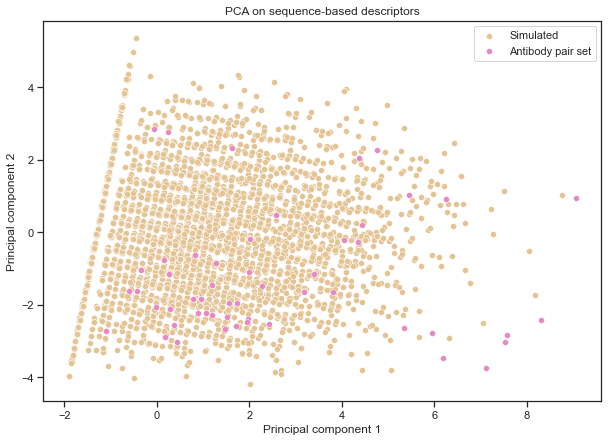

In [18]:
sns.set(style=("ticks"), font_scale=1, palette="Set2")
fig, ax = plt.subplots(1,1, figsize=(10,7))

# add set column to PCA components for plotting
components_set = pd.concat([pd.DataFrame(components), cluster_heavy_pca["Set"].reset_index(drop=True)], axis=1)

# plot sets separately to make sure antibody pair data points are at the front
sns.scatterplot(data=components_set[components_set["Set"] == False], x=0, y=1, label="Simulated", 
    color=pal[6], ax=ax)
sns.scatterplot(data=components_set[components_set["Set"] == True], x=0, y=1, label="Antibody pair set", 
    color=pal[3], ax=ax)
ax.set(title="PCA on sequence-based descriptors", xlabel="Principal component 1", ylabel="Principal component 2")

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/PCA_simulated_data.png", dpi=300, transparent=True,
    bbox_inches="tight")

In [19]:
pc_loadings = pca.components_[0]
feature_ranking = sorted(range(len(pc_loadings)), key=lambda i: abs(pc_loadings[i]), reverse=True)
print("PC1")
for i in feature_ranking[:5]:
    print(i, cluster_heavy_pca_features.columns[i])
    
print("")
pc_loadings = pca.components_[1]
feature_ranking = sorted(range(len(pc_loadings)), key=lambda i: abs(pc_loadings[i]), reverse=True)
print("PC2")
for i in feature_ranking[:5]:
    print(i, cluster_heavy_pca_features.columns[i])

PC1
9 V & J Gene Mutations
7 V Gene Mutations
8 J Gene Mutations
2 CDR3 Amino Acids Length
6 Receptor Amino Acids Length

PC2
6 Receptor Amino Acids Length
2 CDR3 Amino Acids Length
7 V Gene Mutations
9 V & J Gene Mutations
0 CDR1 Amino Acids Length


# Save data

## IGX-Cluster clustered antibodies

In [20]:
antibodies_clustered.to_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs_clustered_IGX.csv", 
    index=False)

## Epitope PDB clone ID mapping

In [21]:
mapping.to_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Epitope_PDB_clone_ID.csv", index=False)

## Clustering input

### SAAB+ 

In [22]:
with open(os.path.dirname(os.getcwd()) + "/data/FASTA/Repertoire_heavy_chains.fasta", "w") as f:
    for i, row in cluster_heavy.iterrows():
        f.write(">" + str(row["Unique Clone Id"]) + "\n")
        f.write(row["Receptor Amino Acids"] + "\n")

### ImmuneBuilder

In [23]:
immune_builder_df = create_immune_builder_dataframe(cluster)
print("Number of antibodies in ImmuneBuilder input dataframe:", len(immune_builder_df))

Number of antibodies in ImmuneBuilder input dataframe: 10490


In [24]:
immune_builder_df.to_csv(os.path.dirname(os.getcwd()) + "/data/clustering/ImmuneBuilder_input.csv", index=False)